In [15]:
import json
import sys 
sys.path.append('/root/circuit-finder')
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results/leap_ioi_vanilla_template"

# Print Hparams

In [24]:

config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/ioi/ioi_vanilla_template_prompts.json
save_dir: results/leap_ioi_vanilla_template
seed: 0
batch_size: 4
total_dataset_size: 1024
ablate_errors: False
first_ablate_layer: 2


# Show Dataset

In [16]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

dataset = results_dir / "dataset.json"
with open(dataset, 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)
df.head()

,clean,corrupt
0,"<|endoftext|>When Christian and Christopher went to the restaurant, Christopher gave a bone to Christian","<|endoftext|>When Edward and Georgia went to the restaurant, Sullivan gave a bone to Christopher"
1,"<|endoftext|>When Jacob and Morgan went to the house, Morgan gave a necklace to Jacob","<|endoftext|>When Victoria and Kelly went to the house, Austin gave a necklace to Morgan"
2,"<|endoftext|>When Graham and Jacob went to the office, Jacob gave a ring to Graham","<|endoftext|>When Charles and Kyle went to the office, Andy gave a ring to Jacob"
3,"<|endoftext|>When Jeremy and Mark went to the store, Mark gave a snack to Jeremy","<|endoftext|>When Laura and Stephen went to the store, Jonathan gave a snack to Mark"


# Plot Graph

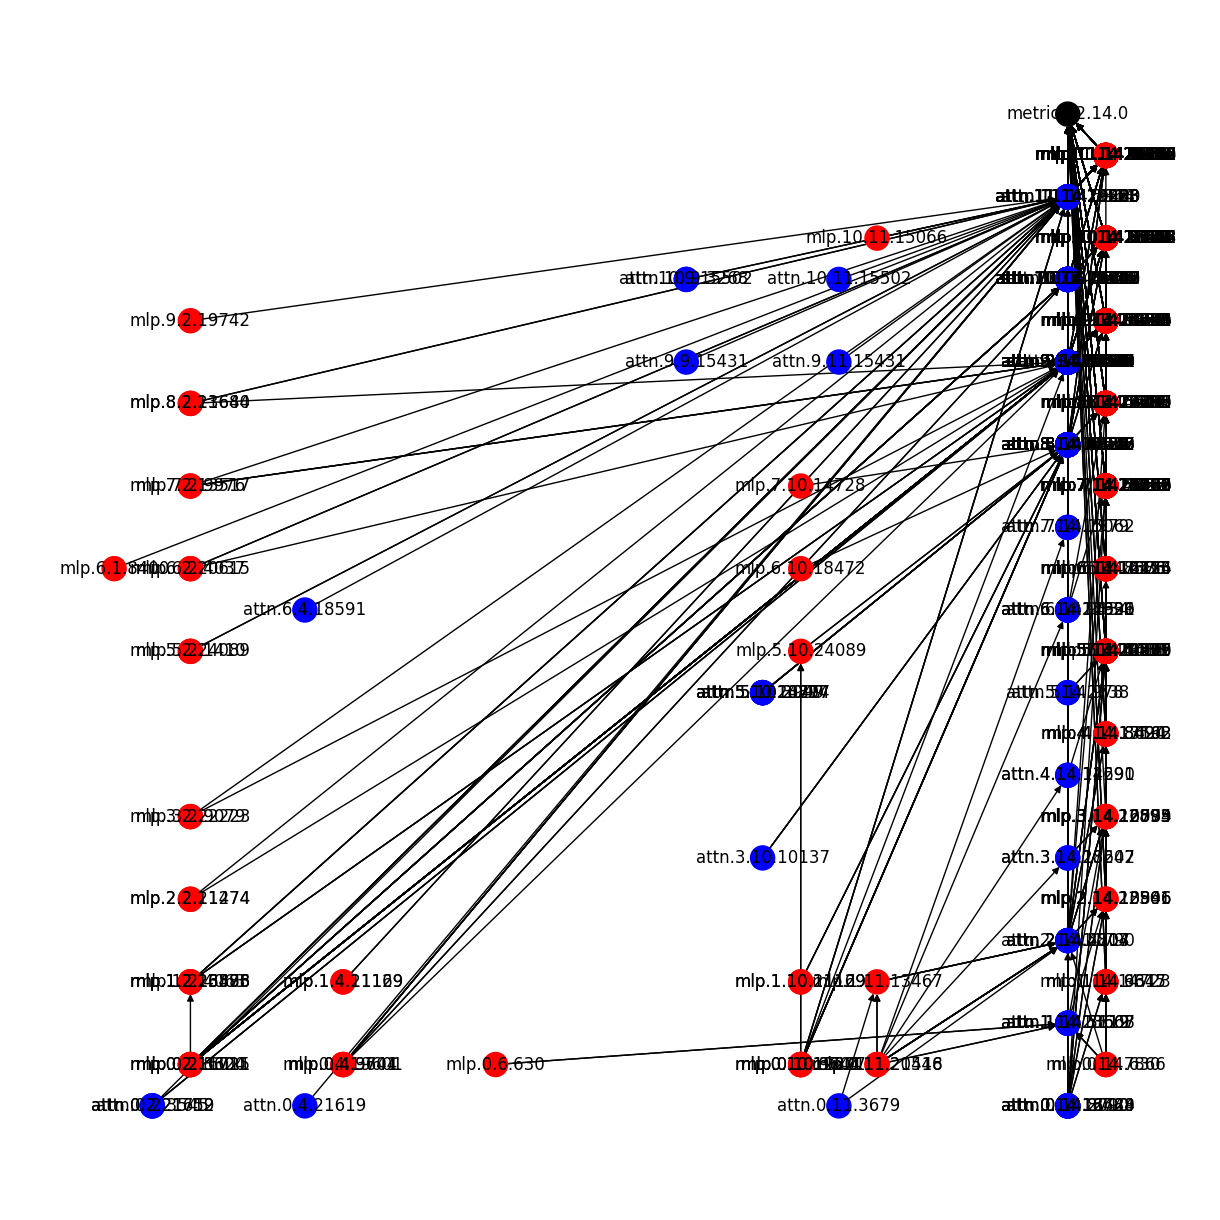

In [19]:
with open(
    results_dir / "leap-graph_threshold=0.005.json"
) as f:
    graph = EAPGraph.from_json(json.load(f))


show_attrib_graph(graph)

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

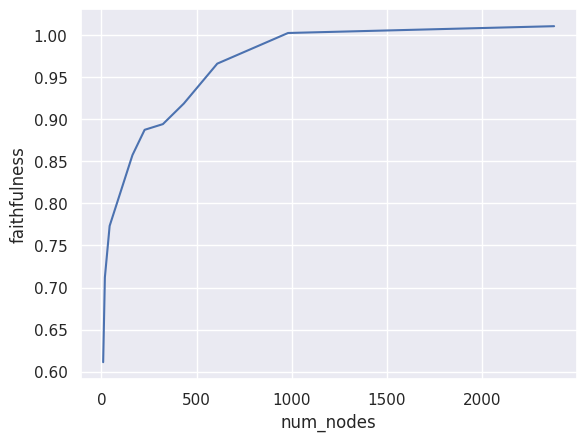

In [22]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")